<a href="https://colab.research.google.com/github/Sandeephm/GoogleColab-codes/blob/master/Flowers_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [0]:
# Import Libraries
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
# Load Flower Data Set

splits = ['train[:70%]', 'train[70%:]']

(training_set, validation_set), dataset_info = tfds.load(
'tf_flowers',
split=splits,
with_info=True,
as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [20]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [21]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [0]:
# Define Rescaled size of Image
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

# Batch Size
BATCH_SIZE = 32

# Training Batch
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
# Validation Batch
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

feature_extractor.trainable = False

In [29]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 8s 100ms/step - loss: 0.7823 - accuracy: 0.7201 - val_loss: 0.4448 - val_accuracy: 0.8474
Epoch 2/6
81/81 [==============================] - 8s 93ms/step - loss: 0.3852 - accuracy: 0.8747 - val_loss: 0.3569 - val_accuracy: 0.8728
Epoch 3/6
81/81 [==============================] - 8s 94ms/step - loss: 0.3096 - accuracy: 0.9027 - val_loss: 0.3200 - val_accuracy: 0.8910
Epoch 4/6
81/81 [==============================] - 8s 93ms/step - loss: 0.2501 - accuracy: 0.9260 - val_loss: 0.3075 - val_accuracy: 0.8965
Epoch 5/6
81/81 [==============================] - 8s 93ms/step - loss: 0.2182 - accuracy: 0.9358 - val_loss: 0.2908 - val_accuracy: 0.9083
Epoch 6/6
81/81 [==============================] - 7s 92ms/step - loss: 0.1917 - accuracy: 0.9467 - val_loss: 0.2959 - val_accuracy: 0.8992


# Model Performance

Text(0.5, 1.0, 'Training and Validation Loss')

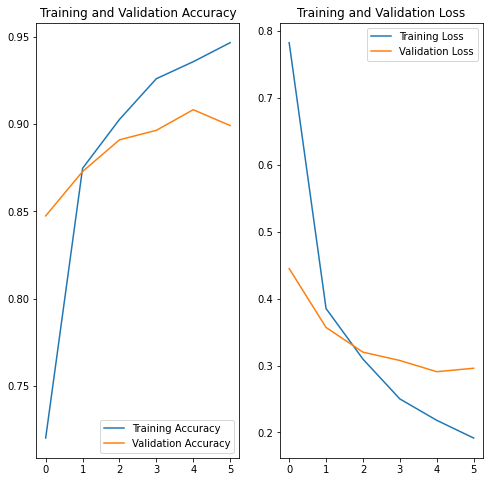

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Evaluating the Model

In [33]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [34]:
image_batch, label_batch = next(iter(train_batches))

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['daisy', 'sunflowers', 'daisy', 'daisy', 'tulips', 'sunflowers',
       'sunflowers', 'tulips', 'roses', 'sunflowers', 'daisy', 'tulips',
       'tulips', 'roses', 'roses', 'sunflowers', 'roses', 'dandelion',
       'tulips', 'roses', 'daisy', 'dandelion', 'daisy', 'roses',
       'sunflowers', 'dandelion', 'dandelion', 'daisy', 'tulips', 'roses',
       'tulips', 'roses'], dtype='<U10')

In [35]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            tf.Tensor([1 3 1 1 2 3 3 2 4 3 1 2 2 4 4 3 4 0 2 4 1 0 1 4 3 0 0 1 2 4 2 4], shape=(32,), dtype=int64)
Predicted labels:  [1 3 1 1 2 3 3 2 4 3 1 2 2 4 4 3 4 0 2 4 1 0 1 4 3 0 0 1 2 4 2 4]


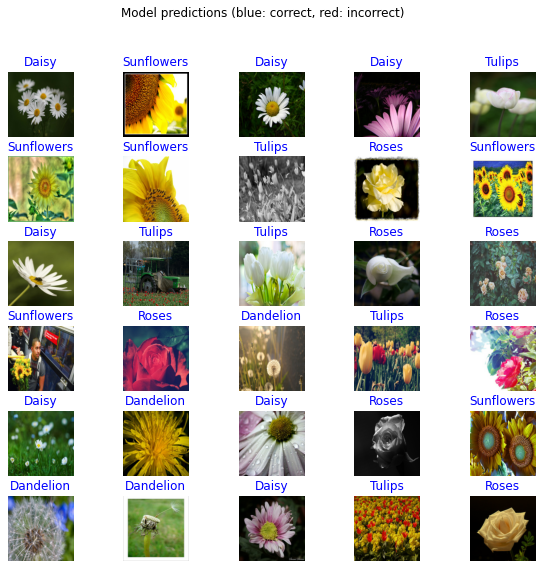

In [36]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Comaprision with Inception v3

In [44]:
# Define Rescaled size of Image
IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

# Batch Size
BATCH_SIZE = 32

# Training Batch
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
# Validation Batch
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [45]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
# Train model for 6 Epochs
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 11s 137ms/step - loss: 0.6955 - accuracy: 0.7575 - val_loss: 0.4300 - val_accuracy: 0.8674
Epoch 2/6
81/81 [==============================] - 10s 124ms/step - loss: 0.3796 - accuracy: 0.8879 - val_loss: 0.3625 - val_accuracy: 0.8837
Epoch 3/6
81/81 [==============================] - 10s 124ms/step - loss: 0.3043 - accuracy: 0.9093 - val_loss: 0.3301 - val_accuracy: 0.8992
Epoch 4/6
81/81 [==============================] - 10s 123ms/step - loss: 0.2593 - accuracy: 0.9249 - val_loss: 0.3268 - val_accuracy: 0.8783
Epoch 5/6
81/81 [==============================] - 10s 124ms/step - loss: 0.2260 - accuracy: 0.9327 - val_loss: 0.3338 - val_accuracy: 0.8783
Epoch 6/6
81/81 [==============================] - 10s 124ms/step - loss: 0.2062 - accuracy: 0.9362 - val_loss: 0.2735 - val_accuracy: 0.9019


Text(0.5, 1.0, 'Training and Validation Loss')

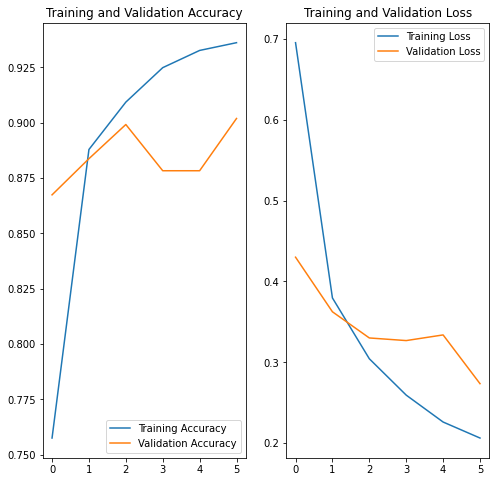

In [46]:
# Plot Accuracy and Loss for Train and Validation Data

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

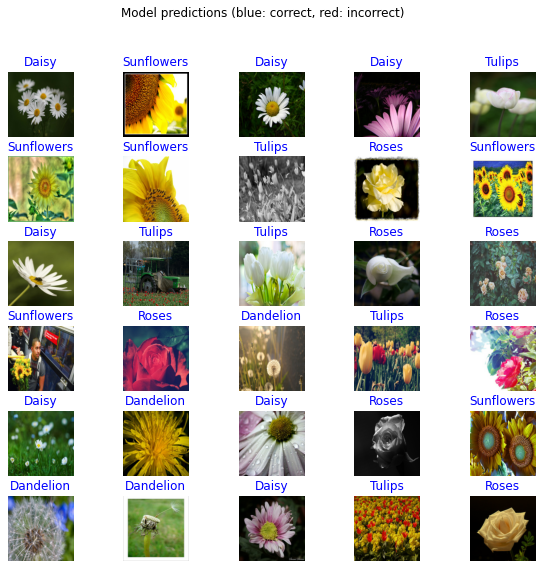

In [47]:
# Do a test on 20 Images 

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Run for 20 Epochs

In [48]:
# Define Rescaled size of Image
IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

# Batch Size
BATCH_SIZE = 32

# Training Batch
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
# Validation Batch
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [49]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
81/81 [==============================] - 11s 133ms/step - loss: 0.7760 - accuracy: 0.7287 - val_loss: 0.4664 - val_accuracy: 0.8429
Epoch 2/20
81/81 [==============================] - 10s 124ms/step - loss: 0.4016 - accuracy: 0.8727 - val_loss: 0.3820 - val_accuracy: 0.8656
Epoch 3/20
81/81 [==============================] - 10s 125ms/step - loss: 0.3204 - accuracy: 0.8945 - val_loss: 0.3288 - val_accuracy: 0.8901
Epoch 4/20
81/81 [==============================] - 10s 126ms/step - loss: 0.2773 - accuracy: 0.9089 - val_loss: 0.2990 - val_accuracy: 0.8955
Epoch 5/20
81/81 [==============================] - 10s 124ms/step - loss: 0.2359 - accuracy: 0.9303 - val_loss: 0.2872 - val_accuracy: 0.9028
Epoch 6/20
81/81 [==============================] - 10s 127ms/step - loss: 0.2135 - accuracy: 0.9393 - val_loss: 0.3221 - val_accuracy: 0.8865
Epoch 7/20
81/81 [==============================] - 10s 125ms/step - loss: 0.1902 - accuracy: 0.9451 - val_loss: 0.2774 - val_accuracy: 0.8928

Text(0.5, 1.0, 'Training and Validation Loss')

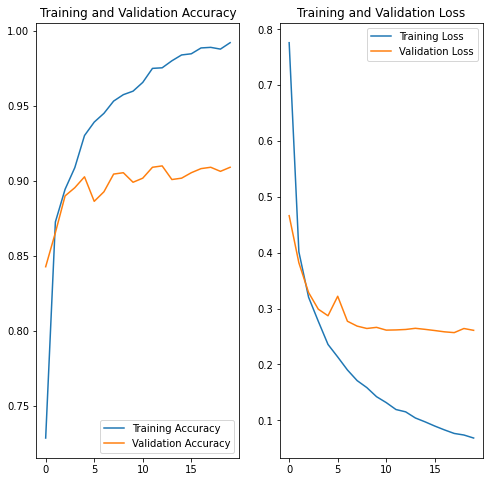

In [50]:
# Plot Accuracy and Loss for Train and Validation Data

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

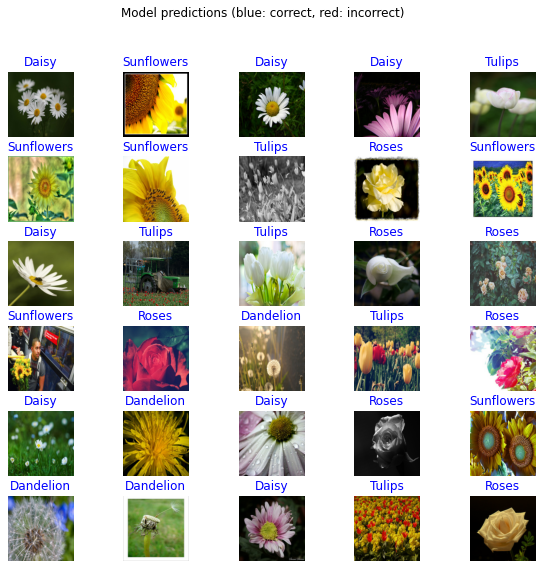

In [51]:
# Do a test on 20 Images 

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")